# Australia Accredited Renewable Energy Progress

### adding imports

In [ ]:
# Importing libraries used for the analysis
import pandas as pd
import numpy as np

import plotly.offline as pyo
import plotly.graph_objs as go

# Using latest version of statsmodel 0.9.0 (otherwise get errors during SARIMAX fit)
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### importing CSV file

In [ ]:
import pandas as pd

historical_data = pd.read_csv('/content/MW_capacity.csv')

In [ ]:
historical_data

,Date,Accredited_MW_Capacity,Committed_MW_Capacity,Probable_MW_Capacity
0,1/1/2016,0,0,424
1,1/8/2016,0,0,424
2,1/15/2016,0,0,424
3,1/22/2016,0,0,424
4,1/29/2016,0,0,424
...,...,...,...,...
449,8/9/2024,21390,7715,4787
450,8/16/2024,21390,8250,4787
451,8/23/2024,21390,8250,4787
452,8/30/2024,21390,8257,4787


In [ ]:
# Set Date column to datetime for time series
historical_data['Date'] = pd.to_datetime(historical_data['Date'],infer_datetime_format=True)

# Data file is sorted from most recent date to the past so sorting by date to go the other way around
historical_data = historical_data.sort_values(by='Date', ascending=True)

# Resetting the index due to the sort_value change
historical_data = historical_data.reset_index(drop = True)

# Dropping all columns except for the Closing Price
historical_data = historical_data.drop(columns=['Committed_MW_Capacity'])

historical_data = historical_data.drop(columns=['Probable_MW_Capacity'])

# Setting the Date as the index
historical_data = historical_data.set_index('Date')

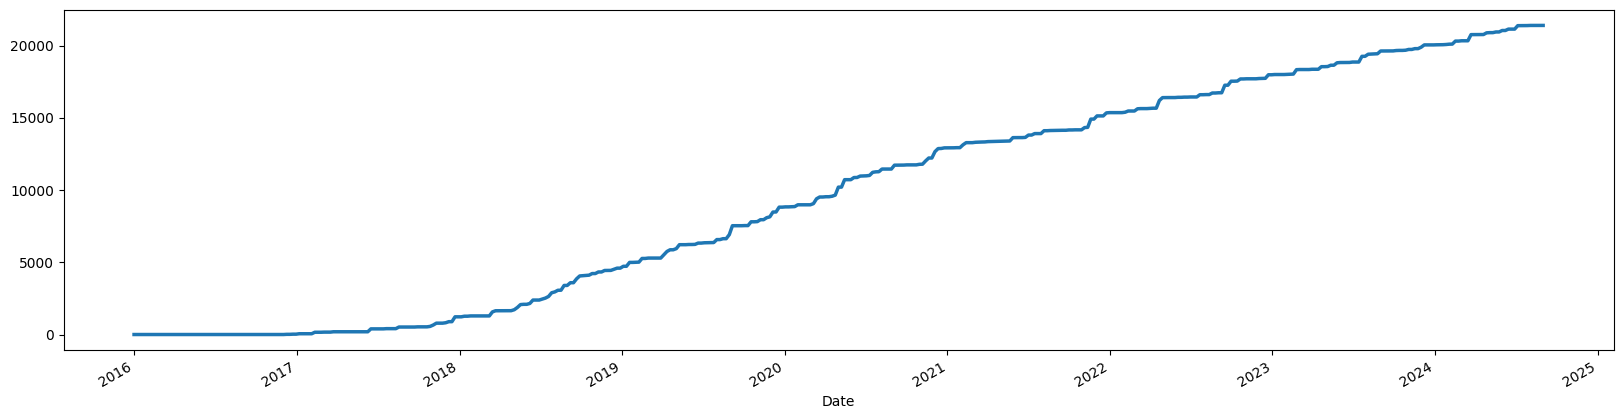

In [ ]:
historical_data['Accredited_MW_Capacity'].plot(lw=2.5, figsize=(20,5));

In [ ]:
df = historical_data.loc['2016-01-01':]

### Cleaning dropping null values

In [ ]:
print(df.isnull().sum())
df = df.dropna()

Accredited_MW_Capacity    0
dtype: int64


In [ ]:
df

,Accredited_MW_Capacity
Date,
2016-01-01,0
2016-01-08,0
2016-01-15,0
2016-01-22,0
2016-01-29,0
...,...
2024-08-09,21390
2024-08-16,21390
2024-08-23,21390


### using arima to evaluate the best order https://zerotomastery.io/blog/arima-sarima-sarimax-explained/

In [ ]:
import warnings
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    try:
        for t in range(len(test)):
            model = ARIMA(history, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        error = mean_squared_error(test, predictions)
    except Exception as e:
        print('Error on ARIMA{}: {}'.format(arima_order, str(e)))
        return float("inf")
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mse = evaluate_arima_model(dataset, order)
                if mse < best_score:
                    best_score, best_cfg = mse, order
                print('ARIMA%s MSE=%.3f' % (order, mse))
    if best_cfg is not None:
        print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    else:
        print('No valid model was found.')

# Example usage
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=114667468.102
ARIMA(0, 0, 1) MSE=28926077.666
ARIMA(0, 0, 2) MSE=10188644.633
ARIMA(0, 1, 0) MSE=12944.413
ARIMA(0, 1, 1) MSE=13043.349
ARIMA(0, 1, 2) MSE=12283.852
ARIMA(0, 2, 0) MSE=23783.374
ARIMA(0, 2, 1) MSE=11067.866
ARIMA(0, 2, 2) MSE=11027.198
ARIMA(1, 0, 0) MSE=13034.934
ARIMA(1, 0, 1) MSE=13119.782
ARIMA(1, 0, 2) MSE=12355.463
ARIMA(1, 1, 0) MSE=13102.316
ARIMA(1, 1, 1) MSE=11066.126
ARIMA(1, 1, 2) MSE=11025.023
ARIMA(1, 2, 0) MSE=15497.284
ARIMA(1, 2, 1) MSE=11020.815
ARIMA(1, 2, 2) MSE=10972.112
ARIMA(2, 0, 0) MSE=13177.648
ARIMA(2, 0, 1) MSE=13084.567
ARIMA(2, 0, 2) MSE=13163.290
ARIMA(2, 1, 0) MSE=12231.572
ARIMA(2, 1, 1) MSE=11018.563
ARIMA(2, 1, 2) MSE=10953.914
ARIMA(2, 2, 0) MSE=14372.209
ARIMA(2, 2, 1) MSE=10947.727
ARIMA(2, 2, 2) MSE=10962.579
Best ARIMA(2, 2, 1) MSE=10947.727


### using Sarima for forecasting

In [ ]:
%%time

# Instantiating the model using SARIMAX, the optimal p, d, q values, and a seasonal order based on 52 .
model = sm.tsa.statespace.SARIMAX(historical_data['Accredited_MW_Capacity'],
                                order=(2, 2, 1),
                                seasonal_order=(2, 2, 1, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

# Fitting the model
SARIMAX_results = model.fit()

CPU times: user 40min 57s, sys: 12.6 s, total: 41min 10s
Wall time: 3min 33s


In [ ]:
# Getting model's predictions of the in-sample data, rounding to two decimal places for price.
SARIMAX_predictions = round(SARIMAX_results.predict(), 0)

# Creating a dataframe of the date index and predictions
SARIMAX_preds = pd.DataFrame(list(zip(list(SARIMAX_predictions.index),list(SARIMAX_predictions))),
                             columns=['Date','Predictedcount']).set_index('Date')

# Merging the original dataframe with predictions for comparison
SARIMAX_predicted_df = pd.merge(historical_data[1:], SARIMAX_preds, left_index=True, right_index=True)

SARIMAX_predicted_df.head()

,Accredited_MW_Capacity,Predictedcount
Date,,
2016-01-08,0,0.0
2016-01-15,0,0.0
2016-01-22,0,0.0
2016-01-29,0,0.0
2016-02-05,0,0.0


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Check for NaN values in the DataFrame
print(SARIMAX_predicted_df.isna().sum())

# Drop rows with NaN values
SARIMAX_predicted_df = SARIMAX_predicted_df.dropna()

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(SARIMAX_predicted_df['Accredited_MW_Capacity'], SARIMAX_predicted_df['Predictedcount'])
rmse = np.sqrt(mse)

# Print the results
print("\tMean Squared Error:", mse)
print("\tRoot Mean Squared Error:", rmse)


Accredited_MW_Capacity    0
Predictedcount            0
dtype: int64
	Mean Squared Error: 19084.832229580574
	Root Mean Squared Error: 138.14786364464914


In [ ]:
# print("\tMean Squared Error:", mean_squared_error(SARIMAX_predicted_df['Kg'],
#                                                   SARIMAX_predicted_df['Predictedcount']))
# print("\tRoot Mean Squared Error:", np.sqrt(mean_squared_error(SARIMAX_predicted_df['Kg'],
#                                                                SARIMAX_predicted_df['Predictedcount'])))

In [ ]:
# Getting 6 months for forecasts
SARIMAX_forecast = round(SARIMAX_results.forecast(steps = 96), 0)


In [ ]:
SARIMAX_forecast

,predicted_mean
454,21597.0
455,21562.0
456,21664.0
457,21650.0
458,21630.0
...,...
545,22008.0
546,21946.0
547,21892.0
548,22019.0


In [ ]:
idx = pd.date_range('2024-08-23',periods=96, freq='W')

SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
                             columns=['Date','ForecastCount']).set_index('Date')

SARIMAX_forecast.head()

,ForecastCount
Date,
2024-08-25,21597.0
2024-09-01,21562.0
2024-09-08,21664.0
2024-09-15,21650.0
2024-09-22,21630.0


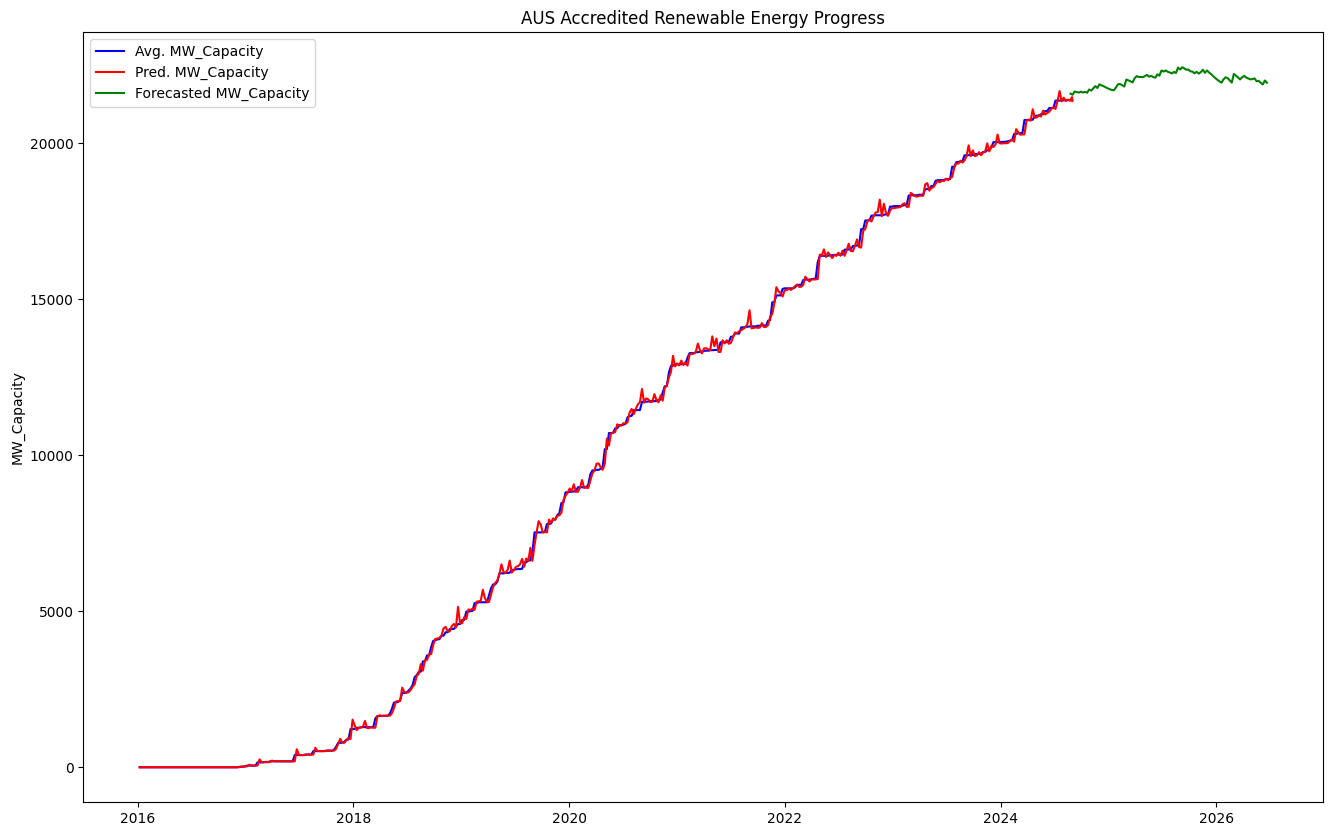

In [ ]:
# Matplotlib Plot for Notebook

fig=plt.figure(figsize=[16,10])
fig.show()
ax=fig.add_subplot(111)

ax.plot(SARIMAX_predicted_df['Accredited_MW_Capacity'],c='b',label='Avg. Accredited_MW_Capacity')
ax.plot(SARIMAX_predicted_df['Predictedcount'],c='r', label='Pred. Accredited_MW_Capacity')
ax.plot(SARIMAX_forecast['ForecastCount'],c='g', label='Forecasted Accredited_MW_Capacity')

plt.legend(loc='best')
plt.ylabel('MW_Capacity')
plt.title('AUS Accredited Renewable Energy Progress')
plt.draw()

In [ ]:
trace0 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['Accredited_MW_Capacity'],
    mode = 'lines',
    name = 'Accredited_MW_Capacity'
)
trace1 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['Predictedcount'],
    mode = 'lines',
    name = 'Predicted Accredited_MW_Capacity'
)
trace2 = go.Scatter(
    x = SARIMAX_forecast.index,
    y = SARIMAX_forecast['ForecastCount'],
    mode = 'lines',
    name = 'Forecast Accredited_MW_Capacity'
)
data = [trace0, trace1, trace2]

layout = go.Layout(
    title = 'AUS Accredited Renewable Energy Progress',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'Accredited_MW_Capacity')
)

fig = go.Figure(data = data, layout = layout)

pyo.plot(fig)

'temp-plot.html'

# AUS Committed Renewable Energy Progress

In [ ]:
import pandas as pd

historical_data1 = pd.read_csv('/content/MW_capacity.csv')

In [ ]:
historical_data1

,Date,Accredited_MW_Capacity,Committed_MW_Capacity,Probable_MW_Capacity
0,1/1/2016,0,0,424
1,1/8/2016,0,0,424
2,1/15/2016,0,0,424
3,1/22/2016,0,0,424
4,1/29/2016,0,0,424
...,...,...,...,...
449,8/9/2024,21390,7715,4787
450,8/16/2024,21390,8250,4787
451,8/23/2024,21390,8250,4787
452,8/30/2024,21390,8257,4787


In [ ]:
# Set Date column to datetime for time series
historical_data1['Date'] = pd.to_datetime(historical_data1['Date'],infer_datetime_format=True)

# Data file is sorted from most recent date to the past so sorting by date to go the other way around
historical_data1 = historical_data1.sort_values(by='Date', ascending=True)

# Resetting the index due to the sort_value change
historical_data1 = historical_data1.reset_index(drop = True)

# Dropping all columns except for the Closing Price
historical_data1 = historical_data1.drop(columns=['Accredited_MW_Capacity'])

# Dropping all columns except for the Closing Price
historical_data1 = historical_data1.drop(columns=['Probable_MW_Capacity'])

# Setting the Date as the index
historical_data1 = historical_data1.set_index('Date')

In [ ]:
last_date = historical_data1.index[-1]
print(last_date)

2024-08-31 00:00:00


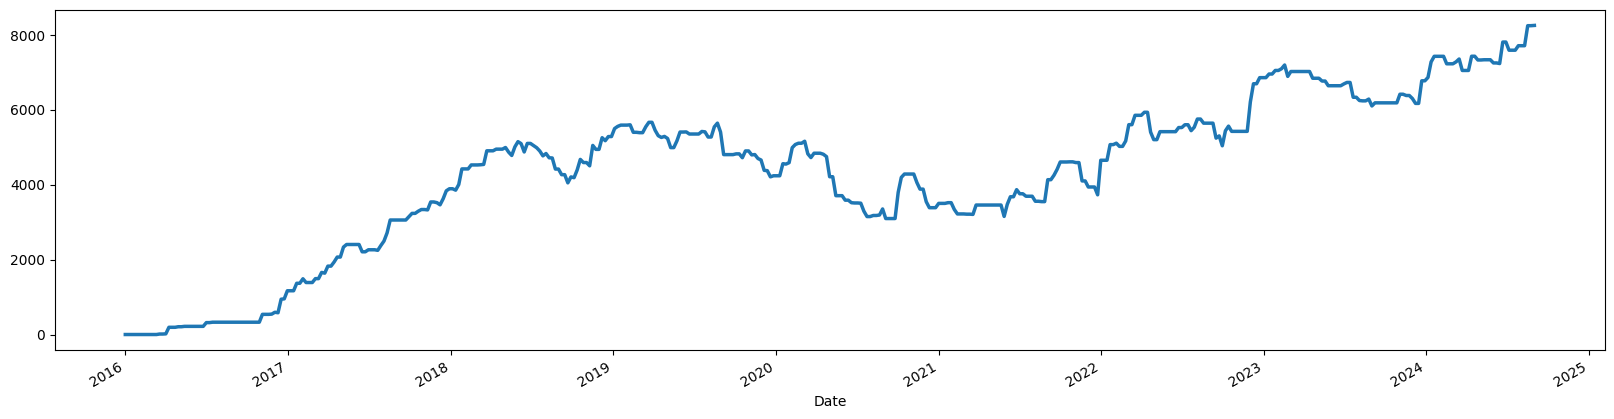

In [ ]:
historical_data1['Committed_MW_Capacity'].plot(lw=2.5, figsize=(20,5));

In [ ]:
df = historical_data1.loc['2016-01-01':]

In [ ]:
print(df.isnull().sum())
df = df.dropna()

Committed_MW_Capacity    0
dtype: int64


In [ ]:
# import warnings
# import numpy as np
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error

# def evaluate_arima_model(X, arima_order):
#     train_size = int(len(X) * 0.66)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]
#     predictions = list()
#     try:
#         for t in range(len(test)):
#             model = ARIMA(history, order=arima_order)
#             model_fit = model.fit()
#             yhat = model_fit.forecast()[0]
#             predictions.append(yhat)
#             history.append(test[t])
#         error = mean_squared_error(test, predictions)
#     except Exception as e:
#         print('Error on ARIMA{}: {}'.format(arima_order, str(e)))
#         return float("inf")
#     return error

# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p, d, q)
#                 mse = evaluate_arima_model(dataset, order)
#                 if mse < best_score:
#                     best_score, best_cfg = mse, order
#                 print('ARIMA%s MSE=%.3f' % (order, mse))
#     if best_cfg is not None:
#         print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
#     else:
#         print('No valid model was found.')

# # Example usage
# p_values = range(0, 3)
# d_values = range(0, 3)
# q_values = range(0, 3)
# warnings.filterwarnings("ignore")

# evaluate_models(df.values, p_values, d_values, q_values)

In [ ]:
%%time

# Instantiating the model using SARIMAX, the optimal p, d, q values, and a seasonal order based on 52 .
model_Committed_MW_Capacity = sm.tsa.statespace.SARIMAX(historical_data1['Committed_MW_Capacity'],
                                order=(2, 2, 1),
                                seasonal_order=(2, 2, 1, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

# Fitting the model
model_Committed_MW_Capacity_SARIMAX_results = model_Committed_MW_Capacity.fit()

CPU times: user 50min 10s, sys: 12.9 s, total: 50min 23s
Wall time: 4min 23s


In [ ]:
# Getting model's predictions of the in-sample data, rounding to two decimal places for price.
model_Committed_MW_Capacity_SARIMAX_predictions = round(model_Committed_MW_Capacity_SARIMAX_results.predict(), 0)

# Creating a dataframe of the date index and predictions
Committed_MW_Capacity_SARIMAX_preds = pd.DataFrame(list(zip(list(model_Committed_MW_Capacity_SARIMAX_predictions.index),list(model_Committed_MW_Capacity_SARIMAX_predictions))),
                             columns=['Date','Predictedcount']).set_index('Date')

# Merging the original dataframe with predictions for comparison
Committed_MW_Capacity_SARIMAX_predicted_df = pd.merge(historical_data1[1:], Committed_MW_Capacity_SARIMAX_preds, left_index=True, right_index=True)

Committed_MW_Capacity_SARIMAX_predicted_df.head()

,Committed_MW_Capacity,Predictedcount
Date,,
2016-01-08,0,0.0
2016-01-15,0,0.0
2016-01-22,0,0.0
2016-01-29,0,0.0
2016-02-05,0,0.0


In [ ]:
Committed_MW_Capacity_SARIMAX_predicted_df.index[-1]

Timestamp('2024-08-31 00:00:00')

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Check for NaN values in the DataFrame
print(Committed_MW_Capacity_SARIMAX_predicted_df.isna().sum())

# Drop rows with NaN values
Committed_MW_Capacity_SARIMAX_predicted_df = Committed_MW_Capacity_SARIMAX_predicted_df.dropna()

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(Committed_MW_Capacity_SARIMAX_predicted_df['Committed_MW_Capacity'], Committed_MW_Capacity_SARIMAX_predicted_df['Predictedcount'])
rmse = np.sqrt(mse)

# Print the results
print("\tMean Squared Error:", mse)
print("\tRoot Mean Squared Error:", rmse)


Committed_MW_Capacity    0
Predictedcount           0
dtype: int64
	Mean Squared Error: 51931.54966887417
	Root Mean Squared Error: 227.88494831575466


In [ ]:
# # Getting 6 months for forecasts
# Committed_MW_Capacity_SARIMAX_forecast = round(model_Committed_MW_Capacity_SARIMAX_results.forecast(steps = 96), 0)
# idxs = pd.date_range('2024-08-23', '2026-05-23', freq='B')

# Committed_MW_Capacity_SARIMAX_forecast = pd.DataFrame(list(zip(list(idxs),list(Committed_MW_Capacity_SARIMAX_forecast))),
#                              columns=['Date','ForecastCount']).set_index('Date')

# Committed_MW_Capacity_SARIMAX_forecast

In [ ]:
# Forecast for 96 weeks
Committed_MW_Capacity_SARIMAX_forecast = round(model_Committed_MW_Capacity_SARIMAX_results.forecast(steps=96), 0)

# Generate date range for 96 weeks from 2024-08-23 with a weekly frequency ('W')
idxs = pd.date_range('2024-08-23', periods=96, freq='W')

# Create DataFrame for the forecast
Committed_MW_Capacity_SARIMAX_forecast = pd.DataFrame(
    list(zip(list(idxs), list(Committed_MW_Capacity_SARIMAX_forecast))),
    columns=['Date', 'ForecastCount']
).set_index('Date')

Committed_MW_Capacity_SARIMAX_forecast

,ForecastCount
Date,
2024-08-25,8207.0
2024-09-01,8290.0
2024-09-08,8297.0
2024-09-15,8436.0
2024-09-22,8483.0
...,...
2026-05-24,14172.0
2026-05-31,14605.0
2026-06-07,14685.0


In [ ]:
Committed_MW_Capacity_SARIMAX_forecast.index[-1]

Timestamp('2026-06-21 00:00:00')

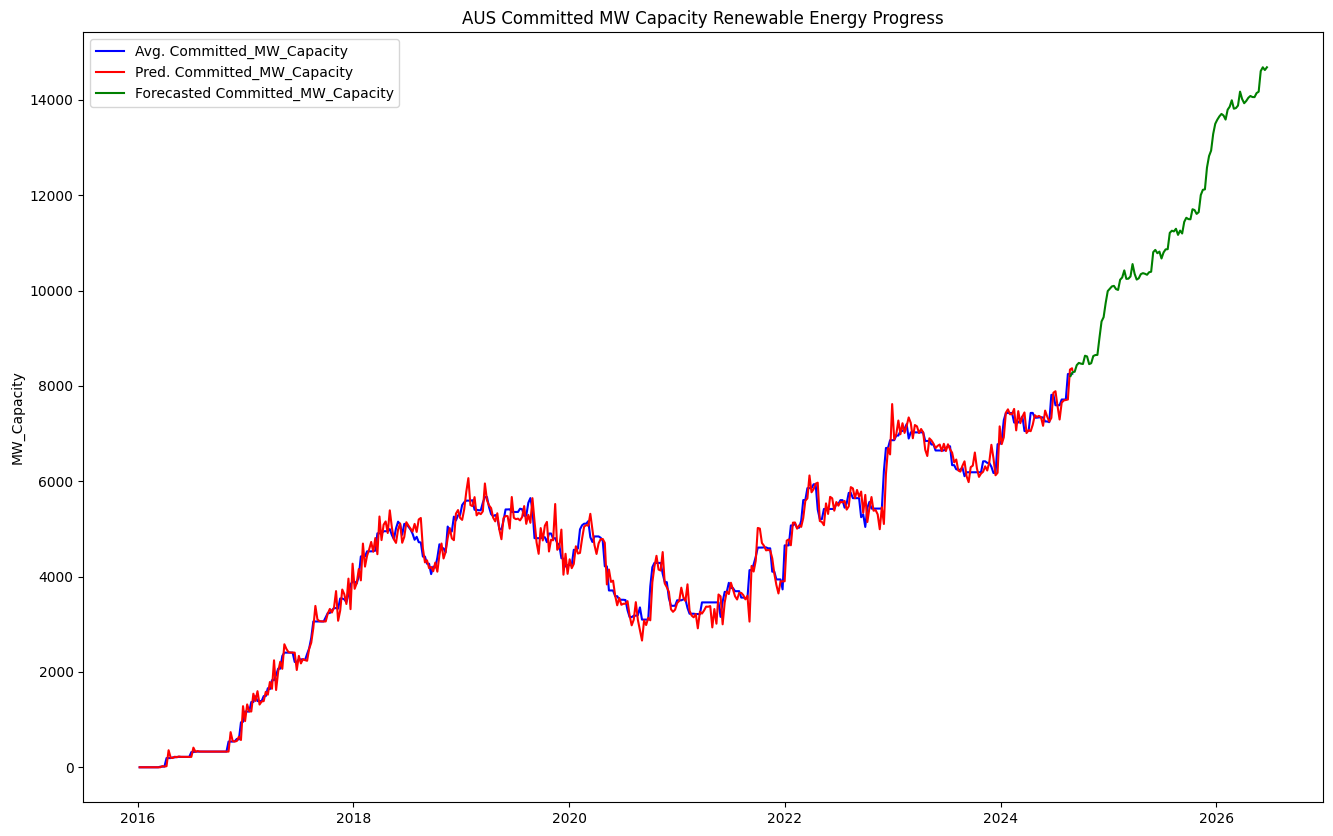

In [ ]:
# Matplotlib Plot for Notebook

fig=plt.figure(figsize=[16,10])
fig.show()
ax=fig.add_subplot(111)

ax.plot(Committed_MW_Capacity_SARIMAX_predicted_df['Committed_MW_Capacity'],c='b',label='Avg. Committed_MW_Capacity')
ax.plot(Committed_MW_Capacity_SARIMAX_predicted_df['Predictedcount'],c='r', label='Pred. Committed_MW_Capacity')
ax.plot(Committed_MW_Capacity_SARIMAX_forecast['ForecastCount'],c='g', label='Forecasted Committed_MW_Capacity')

plt.legend(loc='best')
plt.ylabel('MW_Capacity')
plt.title('AUS Committed MW Capacity Renewable Energy Progress')
plt.draw()

In [ ]:
trace0a = go.Scatter(
    x = Committed_MW_Capacity_SARIMAX_predicted_df.index,
    y = Committed_MW_Capacity_SARIMAX_predicted_df['Committed_MW_Capacity'],
    mode = 'lines',
    name = 'Committed_MW_Capacity'
)
trace1a = go.Scatter(
    x = Committed_MW_Capacity_SARIMAX_predicted_df.index,
    y = Committed_MW_Capacity_SARIMAX_predicted_df['Predictedcount'],
    mode = 'lines',
    name = 'Predicted Committed_MW_Capacity'
)
trace2a = go.Scatter(
    x = Committed_MW_Capacity_SARIMAX_forecast.index,
    y = Committed_MW_Capacity_SARIMAX_forecast['ForecastCount'],
    mode = 'lines',
    name = 'Forecast Committed_MW_Capacity'
)
data1 = [trace0a, trace1a, trace2a]

layout1 = go.Layout(
    title = 'AUS Committed_MW_Capacity Renewable Energy Progress',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'MW_Capacity')
)

fig1 = go.Figure(data = data1, layout = layout1)

pyo.plot(fig1)

'temp-plot.html'

#AUS Probable Renewable Energy Progress

In [ ]:
import pandas as pd

historical_data2 = pd.read_csv('/content/MW_capacity.csv')

In [ ]:
historical_data2

,Date,Accredited_MW_Capacity,Committed_MW_Capacity,Probable_MW_Capacity
0,1/1/2016,0,0,424
1,1/8/2016,0,0,424
2,1/15/2016,0,0,424
3,1/22/2016,0,0,424
4,1/29/2016,0,0,424
...,...,...,...,...
449,8/9/2024,21390,7715,4787
450,8/16/2024,21390,8250,4787
451,8/23/2024,21390,8250,4787
452,8/30/2024,21390,8257,4787


In [ ]:
# Set Date column to datetime for time series
historical_data2['Date'] = pd.to_datetime(historical_data2['Date'],infer_datetime_format=True)

# Data file is sorted from most recent date to the past so sorting by date to go the other way around
historical_data2 = historical_data2.sort_values(by='Date', ascending=True)

# Resetting the index due to the sort_value change
historical_data2 = historical_data2.reset_index(drop = True)

# Dropping all columns except for the Closing Price
historical_data2 = historical_data2.drop(columns=['Accredited_MW_Capacity'])

# Dropping all columns except for the Closing Price
historical_data2 = historical_data2.drop(columns=['Committed_MW_Capacity'])

# Setting the Date as the index
historical_data2 = historical_data2.set_index('Date')

In [ ]:
last_date = historical_data2.index[-1]
print(last_date)

2024-08-31 00:00:00


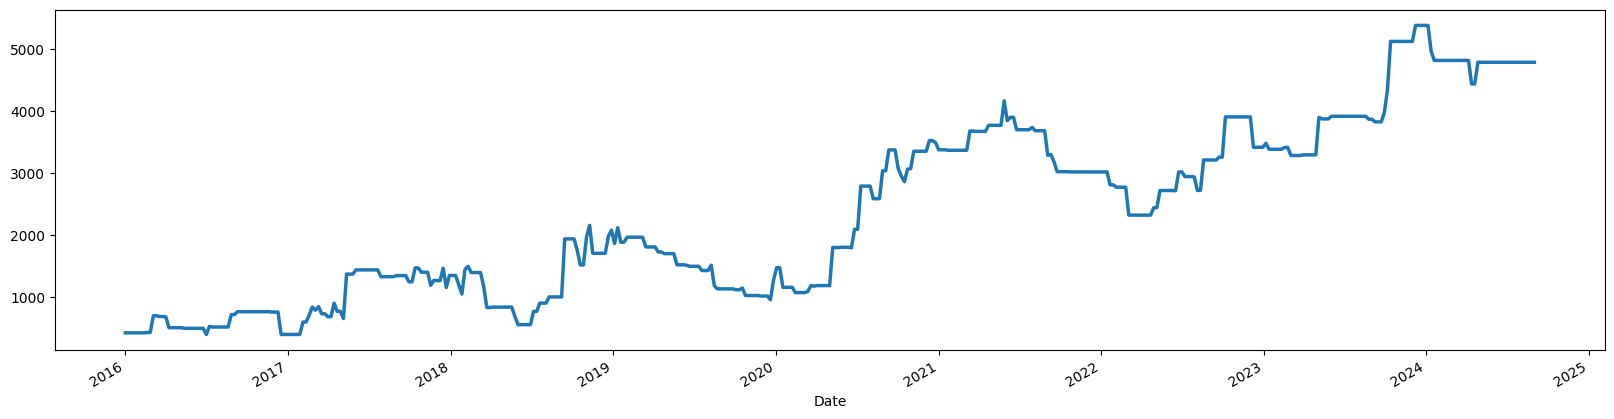

In [ ]:
historical_data2['Probable_MW_Capacity'].plot(lw=2.5, figsize=(20,5));

In [ ]:
df = historical_data2.loc['2016-01-01':]

In [ ]:
print(df.isnull().sum())
df = df.dropna()

Probable_MW_Capacity    0
dtype: int64


In [ ]:
# import warnings
# import numpy as np
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error

# def evaluate_arima_model(X, arima_order):
#     train_size = int(len(X) * 0.66)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]
#     predictions = list()
#     try:
#         for t in range(len(test)):
#             model = ARIMA(history, order=arima_order)
#             model_fit = model.fit()
#             yhat = model_fit.forecast()[0]
#             predictions.append(yhat)
#             history.append(test[t])
#         error = mean_squared_error(test, predictions)
#     except Exception as e:
#         print('Error on ARIMA{}: {}'.format(arima_order, str(e)))
#         return float("inf")
#     return error

# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p, d, q)
#                 mse = evaluate_arima_model(dataset, order)
#                 if mse < best_score:
#                     best_score, best_cfg = mse, order
#                 print('ARIMA%s MSE=%.3f' % (order, mse))
#     if best_cfg is not None:
#         print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
#     else:
#         print('No valid model was found.')

# # Example usage
# p_values = range(0, 3)
# d_values = range(0, 3)
# q_values = range(0, 3)
# warnings.filterwarnings("ignore")

# evaluate_models(df.values, p_values, d_values, q_values)

In [ ]:
%%time

# Instantiating the model using SARIMAX, the optimal p, d, q values, and a seasonal order based on 52 .
model_Probable_MW_Capacity = sm.tsa.statespace.SARIMAX(historical_data2['Probable_MW_Capacity'],
                                order=(2, 2, 1),
                                seasonal_order=(2, 2, 1, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

# Fitting the model
model_Probable_MW_Capacity_SARIMAX_results = model_Probable_MW_Capacity.fit()

CPU times: user 41min 57s, sys: 12.1 s, total: 42min 9s
Wall time: 3min 37s


In [ ]:
# Getting model's predictions of the in-sample data, rounding to two decimal places for price.
model_Probable_MW_Capacity_SARIMAX_predictions = round(model_Probable_MW_Capacity_SARIMAX_results.predict(), 0)

# Creating a dataframe of the date index and predictions
Probable_MW_Capacity_SARIMAX_preds = pd.DataFrame(list(zip(list(model_Probable_MW_Capacity_SARIMAX_predictions.index),list(model_Probable_MW_Capacity_SARIMAX_predictions))),
                             columns=['Date','Predictedcount']).set_index('Date')

# Merging the original dataframe with predictions for comparison
Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df = pd.merge(historical_data2[1:], Probable_MW_Capacity_SARIMAX_preds, left_index=True, right_index=True)

Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df.head()

,Probable_MW_Capacity,Predictedcount
Date,,
2016-01-08,424,735.0
2016-01-15,424,439.0
2016-01-22,424,424.0
2016-01-29,424,424.0
2016-02-05,424,424.0


In [ ]:
Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df.index[-1]

Timestamp('2024-08-31 00:00:00')

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Check for NaN values in the DataFrame
print(Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df.isna().sum())

# Drop rows with NaN values
Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df = Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df.dropna()

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df['Probable_MW_Capacity'], Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df['Predictedcount'])
rmse = np.sqrt(mse)

# Print the results
print("\tMean Squared Error:", mse)
print("\tRoot Mean Squared Error:", rmse)

Probable_MW_Capacity    0
Predictedcount          0
dtype: int64
	Mean Squared Error: 51206.75496688742
	Root Mean Squared Error: 226.28909599644305


In [ ]:
# Forecast for 96 weeks
Probable_MW_Capacity_SARIMAX_forecast = round(model_Probable_MW_Capacity_SARIMAX_results.forecast(steps=96), 0)

# Generate date range for 96 weeks from 2024-08-23 with a weekly frequency ('W')
idxs = pd.date_range('2024-08-23', periods=96, freq='W')

# Create DataFrame for the forecast
Probable_MW_Capacity_SARIMAX_forecast = pd.DataFrame(
    list(zip(list(idxs), list(Probable_MW_Capacity_SARIMAX_forecast))),
    columns=['Date', 'ForecastCount']
).set_index('Date')

Probable_MW_Capacity_SARIMAX_forecast

,ForecastCount
Date,
2024-08-25,4747.0
2024-09-01,4727.0
2024-09-08,4810.0
2024-09-15,5289.0
2024-09-22,5718.0
...,...
2026-05-24,6602.0
2026-05-31,6674.0
2026-06-07,6639.0


In [ ]:
Probable_MW_Capacity_SARIMAX_forecast.index[-1]

Timestamp('2026-06-21 00:00:00')

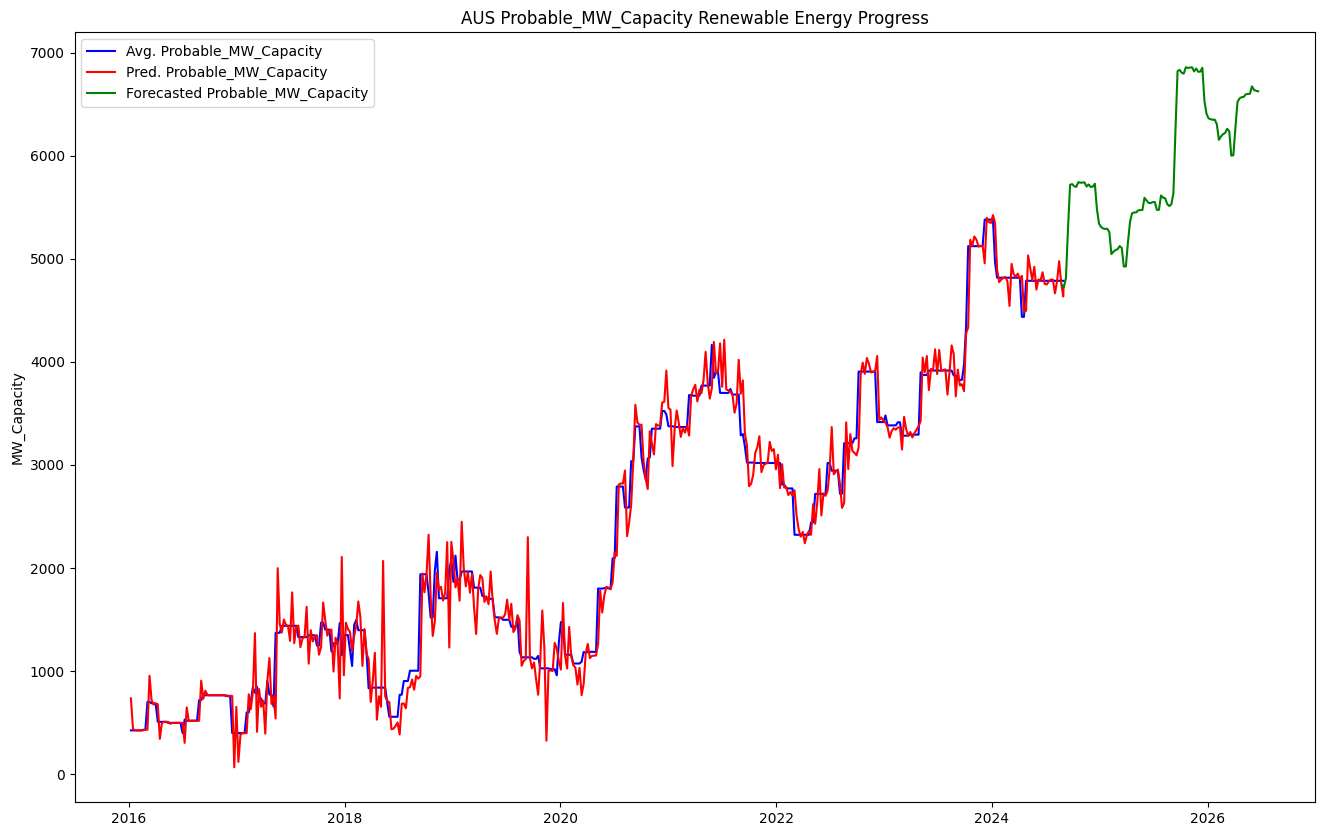

In [ ]:
# Matplotlib Plot for Notebook

fig=plt.figure(figsize=[16,10])
fig.show()
ax=fig.add_subplot(111)

ax.plot(Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df['Probable_MW_Capacity'],c='b',label='Avg. Probable_MW_Capacity')
ax.plot(Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df['Predictedcount'],c='r', label='Pred. Probable_MW_Capacity')
ax.plot(Probable_MW_Capacity_SARIMAX_forecast['ForecastCount'],c='g', label='Forecasted Probable_MW_Capacity')

plt.legend(loc='best')
plt.ylabel('MW_Capacity')
plt.title('AUS Probable_MW_Capacity Renewable Energy Progress')
plt.draw()

In [ ]:
trace0b = go.Scatter(
    x = Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df.index,
    y = Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df['Probable_MW_Capacity'],
    mode = 'lines',
    name = 'Probable_MW_Capacity'
)
trace1b = go.Scatter(
    x = Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df.index,
    y = Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df['Predictedcount'],
    mode = 'lines',
    name = 'Predicted Probable_MW_Capacity'
)
trace2b = go.Scatter(
    x = Probable_MW_Capacity_SARIMAX_forecast.index,
    y = Probable_MW_Capacity_SARIMAX_forecast['ForecastCount'],
    mode = 'lines',
    name = 'Forecast Probable_MW_Capacity'
)
data2 = [trace0b, trace1b, trace2b]

layout2 = go.Layout(
    title = 'AUS Probable_MW_Capacity Renewable Energy Progress',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'MW_Capacity')
)

fig2 = go.Figure(data = data2, layout = layout2)

pyo.plot(fig2)

'temp-plot.html'

In [ ]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Accredited MW Capacity
trace0 = go.Scatter(
    x=SARIMAX_predicted_df.index,
    y=SARIMAX_predicted_df['Accredited_MW_Capacity'],
    mode='lines',
    name='Accredited_MW_Capacity'
)
trace1 = go.Scatter(
    x=SARIMAX_predicted_df.index,
    y=SARIMAX_predicted_df['Predictedcount'],
    mode='lines',
    name='Predicted Accredited_MW_Capacity'
)
trace2 = go.Scatter(
    x=SARIMAX_forecast.index,
    y=SARIMAX_forecast['ForecastCount'],
    mode='lines',
    name='Forecast Accredited_MW_Capacity'
)

# Committed MW Capacity
trace0a = go.Scatter(
    x=Committed_MW_Capacity_SARIMAX_predicted_df.index,
    y=Committed_MW_Capacity_SARIMAX_predicted_df['Committed_MW_Capacity'],
    mode='lines',
    name='Committed_MW_Capacity'
)
trace1a = go.Scatter(
    x=Committed_MW_Capacity_SARIMAX_predicted_df.index,
    y=Committed_MW_Capacity_SARIMAX_predicted_df['Predictedcount'],
    mode='lines',
    name='Predicted Committed_MW_Capacity'
)
trace2a = go.Scatter(
    x=Committed_MW_Capacity_SARIMAX_forecast.index,
    y=Committed_MW_Capacity_SARIMAX_forecast['ForecastCount'],
    mode='lines',
    name='Forecast Committed_MW_Capacity'
)

# Probable MW Capacity
trace0b = go.Scatter(
    x=Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df.index,
    y=Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df['Probable_MW_Capacity'],
    mode='lines',
    name='Probable_MW_Capacity'
)
trace1b = go.Scatter(
    x=Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df.index,
    y=Probable_MW_Capacity_SARIMAX_preds_SARIMAX_predicted_df['Predictedcount'],
    mode='lines',
    name='Predicted Probable_MW_Capacity'
)
trace2b = go.Scatter(
    x=Probable_MW_Capacity_SARIMAX_forecast.index,
    y=Probable_MW_Capacity_SARIMAX_forecast['ForecastCount'],
    mode='lines',
    name='Forecast Probable_MW_Capacity'
)

# Combine all traces into one plot
data = [trace0, trace1, trace2, trace0a, trace1a, trace2a, trace0b, trace1b, trace2b]

# Define layout for the combined plot
layout = go.Layout(
    title='AUS Renewable Energy Progress - Accredited, Committed, and Probable MW Capacity',
    xaxis=dict(title='Date'),
    yaxis=dict(title='MW_Capacity')
)

# Create figure with combined data and layout
fig = go.Figure(data=data, layout=layout)

# Plot the combined figure
pyo.plot(fig)


'temp-plot.html'